In [86]:
import jieba
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import random
import pickle

In [95]:
class DbscanClustering():
    def __init__(self, stopwords_path=None):
        self.stopwords = self.load_stopwords(stopwords_path)
        self.vectorizer = CountVectorizer()
        self.transformer = TfidfTransformer()
        self.result = {}
        self.corpus_path = ""
#         self.sf = []

    def load_stopwords(self, stopwords=None):
        """
        加载停用词
        :param stopwords:
        :return:
        """
        if stopwords:
            with open(stopwords, 'r', encoding='utf-8') as f:
                return [line.strip() for line in f]
        else:
            return []

    def preprocess_data(self, corpus_path):
        """
        文本预处理，每行一个文本
        :param corpus_path:
        :return:
        """
        self.corpus_path = corpus_path
        self.corpus = []
        count = 0
        with open(corpus_path, 'r', encoding='utf-8') as f:
            file1 = open("../data/documents_10000_clean.txt","w")
            for line in f:
                line = line.strip()
                line = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ", line)
                clean_str = ' '.join([word for word in jieba.lcut(line) \
                                      if word != " " and word != "\t" and word not in self.stopwords])
                file1.write(clean_str + "\n")
                self.corpus.append(clean_str)
                count += 1
                if count == 10000: break
            file1.close()
        return self.corpus

    def get_text_tfidf_matrix(self, corpus):
        """
        获取tfidf矩阵
        :param corpus:
        :return:
        """
        
        self.vectorizer.fit(corpus)
        vectorized_corpus = self.vectorizer.transform(corpus)
        self.transformer.fit(vectorized_corpus)
        tfidf = self.transformer.transform(vectorized_corpus)
#         tfidf = self.transformer.fit_transform(self.vectorizer.fit_transform(corpus))

        # 获取词袋中所有词语
#         self.words = self.vectorizer.get_feature_names()

        # 获取tfidf矩阵中权重
        weights = tfidf.toarray()
        return weights

    def pca(self, weights, n_components=5):
        """
        PCA对数据进行降维
        :param weights:
        :param n_components:
        :return:
        """
        self.pca_trans = PCA(n_components=n_components)
        self.pca_trans.fit(weights)
        return self.pca_trans.transform(weights)
    
    def export_result(self):
        #输出结果
        with open(self.corpus_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for cluster, indexes in self.result.items():
                file = open('../data/clusters/' + str(cluster) + '.txt', 'w')
                for index in indexes:
                    file.write("document"+str(index)+": " + lines[index] + "\n")
                file.close()

    def dbscan(self, corpus_path, eps=0.1, min_samples=3, pca_components=5, fig=True):
        """
        DBSCAN：基于密度的文本聚类算法
        :param corpus_path: 语料路径，每行一个文本
        :param eps: DBSCA中半径参数
        :param min_samples: DBSCAN中半径eps内最小样本数目
        :param fig: 是否对降维后的样本进行画图显示
        :return:
        """
        corpus = self.preprocess_data(corpus_path)
        self.weights = self.get_text_tfidf_matrix(corpus)

        self.pca_weights = self.pca(self.weights, pca_components)

        clf = DBSCAN(eps=eps, min_samples=min_samples)

        y = clf.fit_predict(self.pca_weights)

        if fig:
            plt.scatter(self.pca_weights[:, 0], self.pca_weights[:, 1], c=y)
            plt.show()

        # 每个样本所属的簇
        for text_idx, label_idx in enumerate(y):
            if label_idx not in self.result:
                self.result[label_idx] = [text_idx]
            else:
                self.result[label_idx].append(text_idx)
        return self.result

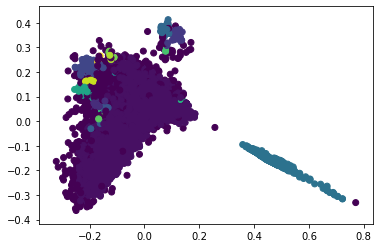

{0: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 179, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 

In [96]:
if __name__ == '__main__':
    dbscan = DbscanClustering(stopwords_path='../data/stop_words.txt')
    result = dbscan.dbscan('../data/documents_labeled_more.txt', eps=0.04, min_samples=5, pca_components = 5)
    print(result)

In [8]:
#到处数据
dbscan.export_result()

In [89]:
#查看异常文档数量
len(result[-1])

719

In [97]:
new_vec = dbscan.vectorizer.transform(['财经 银行 哈哈哈哈哈哈哈 股市', '你好 上涨'])
new_tfidf = dbscan.transformer.transform(new_vec)
new_pca_weight = dbscan.pca_trans.transform(new_tfidf.toarray())

In [110]:
print(new_pca_weight)

[[ 0.11236492  0.09570864 -0.12104674  0.01349204 -0.0960077 ]
 [ 0.11859178  0.03813172 -0.06963218 -0.04192296 -0.08061255]]


In [99]:
with open('../data/CountVectorizer.pkl', 'wb') as fp:
    pickle.dump(dbscan.vectorizer, fp)

In [100]:
with open('../data/TfidfTransformer.pkl', 'wb') as fp:
    pickle.dump(dbscan.transformer, fp)

In [101]:
with open('../data/PCATransformer.pkl', 'wb') as fp:
    pickle.dump(dbscan.pca_trans, fp)

In [103]:
with open('../data/CountVectorizer.pkl', 'rb') as fp:
    CountVecTransformer = pickle.load(fp)

In [104]:
with open('../data/TfidfTransformer.pkl', 'rb') as fp:
    TfidfTransformer = pickle.load(fp)

In [105]:
with open('../data/PCATransformer.pkl', 'rb') as fp:
    PCATransformer = pickle.load(fp)

In [108]:
new_vec = CountVecTransformer.transform(['财经 银行 哈哈哈哈哈哈哈 股市', '你好 上涨'])
new_tfidf = TfidfTransformer.transform(new_vec)
new_pca_weight = PCATransformer.transform(new_tfidf.toarray())

In [107]:
print(new_pca_weight)

[[ 0.11236492  0.09570864 -0.12104674  0.01349204 -0.0960077 ]
 [ 0.11859178  0.03813172 -0.06963218 -0.04192296 -0.08061255]]


In [109]:
print(new_pca_weight)

[[ 0.11236492  0.09570864 -0.12104674  0.01349204 -0.0960077 ]
 [ 0.11859178  0.03813172 -0.06963218 -0.04192296 -0.08061255]]
